# Surrogate NN model training

The NN surrogate model aims to replace the following map:
$$\mathbf{f}  : (C, D) \rightarrow Q(x), \quad F(x) = \mathbb{P}(X\le x), \quad x \in \mathbb{R},$$
where
$$\text{iCDF}: Q(p)=F^{-1}(p) = \min\{x\in \mathbb{R}: F(x)\ge p \}, \quad p\in (0,1).$$

Input: $(C, D)$, fracture density $C \in [2.5, 6.5]$, fractal dimension $D \in [1, 1.3]$

Output: discrete $Q(x), F^{-1}(0.01), F^{-1}(0.03), ..., F^{-1}(0.99)$, 50 points in total.

In [1]:
%%capture
!pip install ray
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [2]:
import pickle as pkl
import numpy as np
from sklearn.neural_network import MLPRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import time
import random
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as T
from functools import partial
from google.colab import files
from datetime import datetime

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename  = '/content/drive/MyDrive/RESEARCH_fracture/seeds20/CD_ICDF_FR.pkl'

with open(filename,'rb') as file:
  [C_d, P_cdf] = pkl.load(file, encoding='latin1') 
P_cdf = np.asarray(P_cdf)
C_d = np.asarray(C_d)
train_size = int(len(P_cdf)*0.8)
X, Y = np.asarray(P_cdf[:train_size]), np.asarray(C_d[:train_size])

print('length of input,', len(P_cdf))
print('length of output,', len(C_d))
print('dimension of input,',len(P_cdf[0]))
print('dimension of output,', len(C_d[0]))
print(C_d[0])

## append C^(1/d), C^(-d), C*d, and 1/d to the input array to create more features.
new_cd = np.concatenate(
    (
    C_d, np.array(
        [
          C_d[:,0]**(1/C_d[:,1]),  ## C^(1/d)
          C_d[:,0]**(-C_d[:,1]),   ## C^(-d)
          C_d[:,0]*C_d[:,1],       ## C*d
          1/C_d[:,1],              ## 1/d 
        ]
        ).T
     ), axis=1
)
new_cd.shape

length of input, 3000
length of output, 3000
dimension of input, 50
dimension of output, 2
[8.23449433 2.65208147]


(3000, 6)

## load data

In [4]:
## data loader
def load_data(new_cd, P_cdf, num_training, num_test):
  """
  load training data from the pickled list: new_cd, P_cdf, divide the training 
  and test data to 8:2, the training set will be split again into 8:2 (train/validate) 
  in hyper-parameter tuning stage
  """

  # Subsample the data
  tensor_X = torch.stack([torch.Tensor(np.reshape(i,(6,))) for i in new_cd]) # transform to torch tensors
  tensor_y = torch.stack([torch.Tensor(np.reshape(i,(50,))) for i in P_cdf])

  test_size = num_training + num_test
  X_train = tensor_X[:num_training]
  y_train = tensor_y[:num_training]

  x_test = tensor_X[num_training:test_size]
  y_test = tensor_y[num_training:test_size]

  train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
  test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

  print('loaded data.')
  return train_dataset, test_dataset

trainset, testset = load_data(
    new_cd, P_cdf, 
    num_training=int(len(new_cd)*0.8), 
    num_test=int(len(new_cd)*0.2),
    )

loaded data.


## ray hyperparameter searching

In [5]:
##define Net with flexible number of layers, number of neurons in each layer,
class Net(nn.Module):
    def __init__(self, ls=[20 for i in range(20)], n_l=5):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, ls[0])
        self.linears = nn.ModuleList(
            [nn.Linear(ls[i], ls[i+1]) for i in range(n_l-1)]
            )
        self.fcend = nn.Linear(ls[n_l-1], 50)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
        x = F.relu(self.fcend(x))
        return x

def hel_loss(P, Q):
  return torch.mean(torch.sqrt(torch.sum((torch.sqrt(P) - torch.sqrt(Q))**2, dim=1)))

def train(config, max_num_epochs=1000):
    random.seed(888)
    np.random.seed(888)
    net = Net(config['ls'], config['n_l'])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    net.to(device) 
    # optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    if config['opt'] == 'rms':
      optimizer = optim.RMSprop(net.parameters(), lr=config["lr"])
    elif config['opt'] == 'sgd':
      optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9, nesterov=True)
    elif config['opt'] == 'ada':
      optimizer = optim.Adagrad(net.parameters(), lr=config["lr"])
    elif config['opt'] == 'adam':
      optimizer = optim.Adam(net.parameters(), lr=config["lr"], betas=(0.9, 0.999), amsgrad=False)

    train_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [train_abs, len(trainset) - train_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=500,
        shuffle=True,
        num_workers=0)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=500,
        shuffle=True,
        num_workers=0)
    
    for epoch in range(max_num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, targets]
          inputs, targets = data
          inputs, targets = inputs.to(device), targets.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = hel_loss(outputs, targets) #use hellinger distance as the loss
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()


      # Validation loss
      val_loss = 0.0
      val_steps = 0

      for i, data in enumerate(valloader, 0):
          with torch.no_grad():
              inputs, targets = data
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = net(inputs)

              loss = hel_loss(outputs, targets)
              # loss = nn.MSELoss()
              # loss = loss(outputs, targets)
              val_loss += loss.cpu().numpy()
              val_steps += 1
      if (epoch+1)%100 == 0:
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps))
    print("Finished Training")
  
def test_loss(net, device="cpu"):

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=len(testset), shuffle=False, num_workers=2)

    with torch.no_grad():
      for data in testloader: #only 1 batch
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        test_loss = nn.MSEloss(outputs, targets)
    return test_loss

In [6]:
def plot_prediction(outputs, targets, inputs, title=''):

    fig1, axs = plt.subplots(len(targets)//4, 4, figsize=(12,8), 
                             sharey = 'row', sharex=True,
                             constrained_layout=True)
    axs = axs.flat
    ylims = [
              [np.min(targets[:4,])-0.2, np.max(targets[:4,])+0.2],
              [np.min(targets[4:,])-0.2, np.max(targets[4:,])+0.2]
    ]
    zeros_ind = outputs==0.   
    for ax, i, out, tar in zip(axs, range(len(outputs)), outputs, targets):
        CD =  inputs[i][:2]
        ax.set_title('p={:.2f}, a={:.2f}'.format(CD[0], CD[1]))
        x = np.linspace(0.01, 0.99, 50)
        ax.plot(x, tar, 'o', label='truth')
        ax.plot(x, out, '*', label='prediction')
        ylim = ylims[0] if i<4 else ylims[1]
        if np.any(zeros_ind):
            ax.plot(x[zeros_ind[i]], 
                    [ylim[0]+0.1 for i in range(len(x[zeros_ind[i]]))],
                    'x', color='r', label='zero predictions')

        ax.set_ylim(ylim)
        ax.set_xlabel('ICDF')
    ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    axs[0].set_ylabel('log(partical arrive time)')
    axs[4].set_ylabel('log(partical arrive time)')
    plt.show()
    fig1.savefig(title+'/test.pdf')
    return
def non_decreasing(L):
    return all(x<=y for x,y in zip(L,L[1:]))
def plot_in1(outputs, targets, inputs, title='', fig_title=''):
    assert non_decreasing(targets[0]), 'P_cdf not increasing'

    fig1, ax = plt.subplots(1, 1, figsize=(5,4), constrained_layout=True,)
    for i, out, tar in zip(range(len(outputs)), outputs, targets):
        # ax.set_title('p, a= %s' %str(inputs.cpu().detach().numpy()[i][:2]))
        x = np.linspace(0.01, 0.99, 50)
        ax.plot(x, tar, '.', ls ='-', ms=1, label='truth')
        ax.plot(x, out, '*', label='prediction')
    ax.set_ylabel('log(partical arrive time)')
    ax.set_xlabel('ICDF')
    # ax.legend()
    plt.show()
    if fig_title == '':
        fig1.savefig(title+'/test_in1.pdf')
    else:
        fig1.savefig(title+'/'+fig_title+'.pdf')
    return

### If results **saved**

In [7]:
path = '/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/'
files = os.listdir(path)
folders = [os.path.join(path, i) for i in files if '.' not in i]
latest_folder = max(folders, key=os.path.getctime)
latest_folder='/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/01-07-2023-16-12-37/'
print(latest_folder)
check_data = torch.load(latest_folder+'/ckp.pt')

best_config = check_data['Best trial config']
best_trained_model = Net(ls=best_config['ls'], n_l=best_config['n_l'])
best_trained_model.load_state_dict( check_data['model_state_dict'])
print(best_trained_model)
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
best_trained_model = best_trained_model.to(device)


/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/01-07-2023-16-12-37/
Net(
  (fc1): Linear(in_features=6, out_features=512, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (fcend): Linear(in_features=256, out_features=50, bias=True)
)


In [8]:
train_dataset, test_dataset = load_data(
    new_cd, P_cdf, 
    num_training=int(len(new_cd)*0.8), 
    num_test=int(len(new_cd)*0.2)
    )

loaded data.


In [9]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=500,
    shuffle=True,
    num_workers=0)
test_loss = 0.
test_steps = 0
for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_trained_model(inputs)

        loss = hel_loss(outputs, targets)
        # loss = nn.MSELoss()
        # loss = loss(outputs, targets)
        test_loss += loss.cpu().numpy()
        test_steps += 1
print(test_loss/test_steps)

0.16147297620773315


### continue training from the best checkpoint

In [10]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
print('training on device:', device)
best_trained_model.to(device) 
# optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
if best_config['opt'] == 'rms':
    optimizer = optim.RMSprop(best_trained_model.parameters(), lr=best_config["lr"])
elif best_config['opt'] == 'sgd':
    optimizer = optim.SGD(best_trained_model.parameters(), lr=best_config["lr"], momentum=0.9, nesterov=True)
elif best_config['opt'] == 'ada':
    optimizer = optim.Adagrad(best_trained_model.parameters(), lr=best_config["lr"])
elif best_config['opt'] == 'adam':
    optimizer = optim.Adam(best_trained_model.parameters(), lr=best_config["lr"], betas=(0.9, 0.999), amsgrad=False)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 100, factor=0.5, verbose=True)

train_abs = int(len(trainset) * 0.8)
train_subset, val_subset = random_split(
    trainset, [train_abs, len(trainset) - train_abs])

trainloader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=500,
    shuffle=True,
    num_workers=0)
valloader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=500,
    shuffle=True,
    num_workers=0)

max_num_epochs = 1000
train_loss = []
validation_loss = []
for epoch in range(max_num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    best_trained_model.train()
    train_steps = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, targets]
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = best_trained_model(inputs)
        loss = hel_loss(outputs, targets) #use hellinger distance as the loss
        # loss = nn.MSELoss()
        # loss = loss(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_steps += 1
    train_loss.append(running_loss/train_steps)    

    # Validation loss
    val_loss = 0.0
    val_steps = 0
    best_trained_model.eval()
    for i, data in enumerate(valloader, 0):
        with torch.no_grad():
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = best_trained_model(inputs)

            loss = hel_loss(outputs, targets)
            # loss = nn.MSELoss()
            # loss = loss(outputs, targets)
            val_loss += loss.cpu().numpy()
            val_steps += 1
    validation_loss.append(val_loss / val_steps)
    if (epoch+1)%500 == 0:
        print(val_loss / val_steps)
    scheduler.step(val_loss)

training on device: cuda:0
Epoch 00318: reducing learning rate of group 0 to 1.1503e-03.
Epoch 00475: reducing learning rate of group 0 to 5.7516e-04.
0.10440569370985031
Epoch 00576: reducing learning rate of group 0 to 2.8758e-04.
Epoch 00677: reducing learning rate of group 0 to 1.4379e-04.
Epoch 00778: reducing learning rate of group 0 to 7.1895e-05.
Epoch 00879: reducing learning rate of group 0 to 3.5947e-05.
Epoch 00980: reducing learning rate of group 0 to 1.7974e-05.
0.10430098325014114


In [11]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=500,
    shuffle=True,
    num_workers=0)
test_loss = 0.
test_steps = 0
for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_trained_model(inputs)

        loss = hel_loss(outputs, targets)
        # loss = nn.MSELoss()
        # loss = loss(outputs, targets)
        test_loss += loss.cpu().numpy()
        test_steps += 1
print('testing loss: ', test_loss/test_steps)

testing loss:  0.0997479185461998


In [12]:
with open(path+'training_stats.pkl', 'wb') as file:
    pkl.dump([train_loss, validation_loss, test_loss/test_steps], file)

[0.08723676 0.07308567 0.20174906 0.06485463 0.0700354  0.0976907
 0.09338926 0.07375691]
600


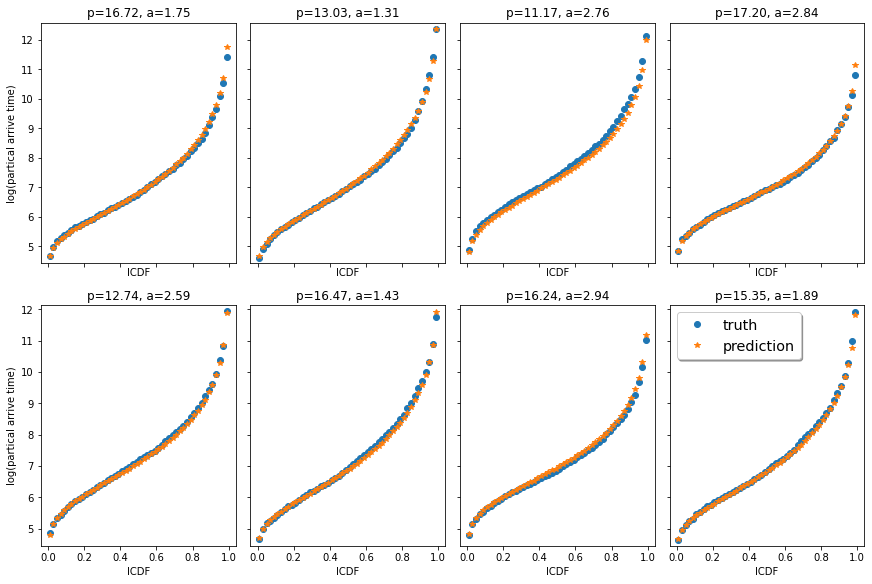

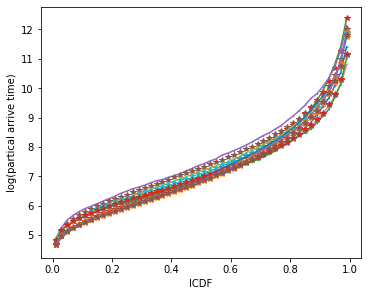

In [13]:
path = latest_folder + '/continue_train'
if not os.path.exists(path):
    os.makedirs(path)
torch.save(
    {
        # 'max_num_epochs': max_num_epochs,
        'model_state_dict': best_trained_model.state_dict(),
    },
    path+'/ckp.pt'
)

np.random.seed(88)
with torch.no_grad():
    inputs, targets = test_dataset[[np.random.randint(0, len(test_dataset), size=(8,))]]
    inputs, targets = inputs.to(device), targets.to(device)
    best_trained_model.eval()
    outputs = best_trained_model(inputs)
print(np.sqrt(np.sum((np.sqrt(outputs.cpu().numpy()) - np.sqrt(targets.cpu().numpy()))**2, axis=1)))
print(len(test_dataset))
plot_prediction(outputs.cpu().numpy(), targets.cpu().numpy(), inputs.cpu().numpy(), title=path)
plot_in1(outputs.cpu(), targets.cpu(), inputs, title=path)

##plot illpose

In [14]:
%%capture
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [15]:
## find the bound of the ICDF as input
min_list = [P_cdf[i][0] for i in range(len(P_cdf))]
max_list = [P_cdf[i][-1] for i in range(len(P_cdf))]
print('minimal starting P_cdf is:', min(min_list))
print('maximal ending P_cdf is:', max(max_list))
print(P_cdf[0])
print(P_cdf[1])

minimal starting P_cdf is: 4.069499374308621
maximal ending P_cdf is: 13.603670238183916
[ 4.62581055  4.97395656  5.17380611  5.34654434  5.47458934  5.58443927
  5.69180524  5.78584322  5.8950932   6.00182981  6.13313147  6.23680882
  6.31661713  6.39739481  6.47217199  6.59161289  6.69044273  6.74383916
  6.83045114  6.92525236  7.0065937   7.07633077  7.19809957  7.28209591
  7.37291984  7.46632767  7.56325979  7.68026115  7.7738684   7.87131729
  7.99768981  8.11571807  8.19825747  8.29726327  8.40042379  8.53534345
  8.6697716   8.79989372  8.9427794   9.08373004  9.23994428  9.38098239
  9.5753343   9.77274915 10.01548845 10.28883367 10.65871373 11.09567398
 11.76847536 12.7414872 ]
[ 4.772491    5.040959    5.19414038  5.3199019   5.40633957  5.50170772
  5.60656074  5.69727994  5.78239753  5.83845081  5.91654186  5.97514729
  6.01914517  6.06150166  6.128238    6.19644757  6.26685236  6.32719185
  6.39283968  6.46514499  6.54271278  6.62102816  6.68079008  6.73654976
  6.79209

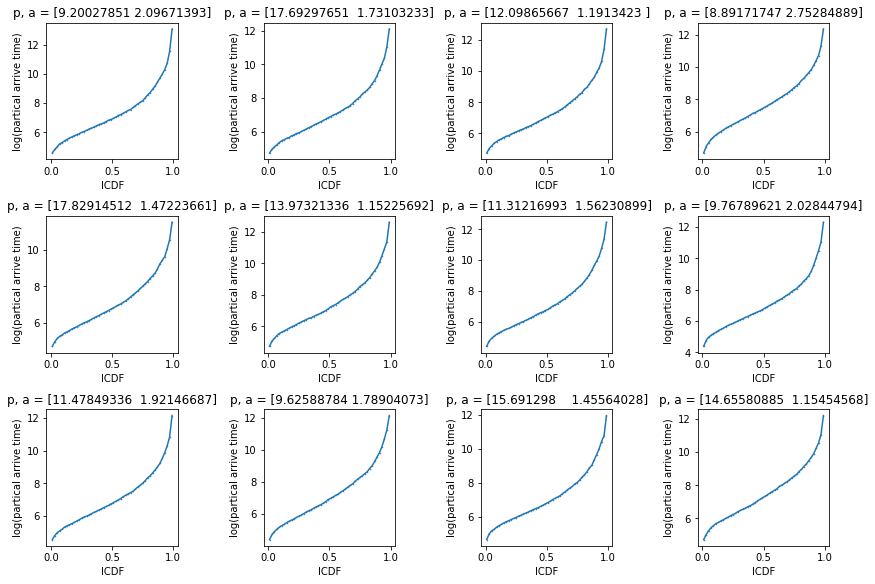

In [16]:
fig1, axs = plt.subplots(3, 4, figsize=(12,8), constrained_layout=True)
axs = axs.flat
np.random.seed(88)
rand_i = np.random.randint(0, high = len(X), size = 12)

for i, ax in zip(range(12), axs):
    ax.set_title('p, a = %s' %str(Y[rand_i[i]]))
    x = np.linspace(0.01, 0.99, 50)
    y = X[rand_i[i]]
    ax.plot(x, y, '.', ls='-', ms=1)
    ax.set_ylabel('log(partical arrive time)')
    ax.set_xlabel('ICDF')

In [17]:
path = '/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/'

In [18]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rcParams['text.usetex'] = True
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


mse time:  0.020953655242919922
hellinger time:  0.029283523559570312
mse time:  0.022499799728393555
hellinger time:  0.030514240264892578
mse time:  0.021478652954101562


hellinger time:  0.029752254486083984


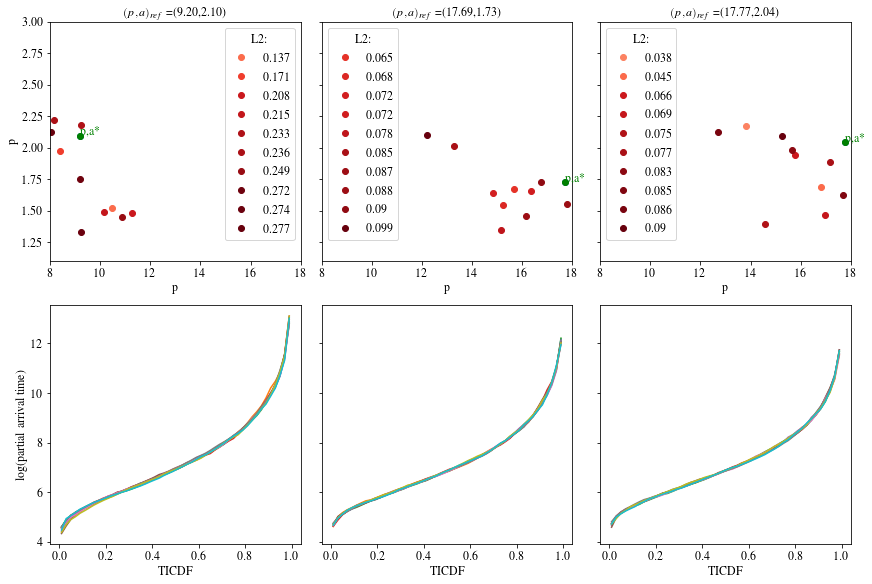

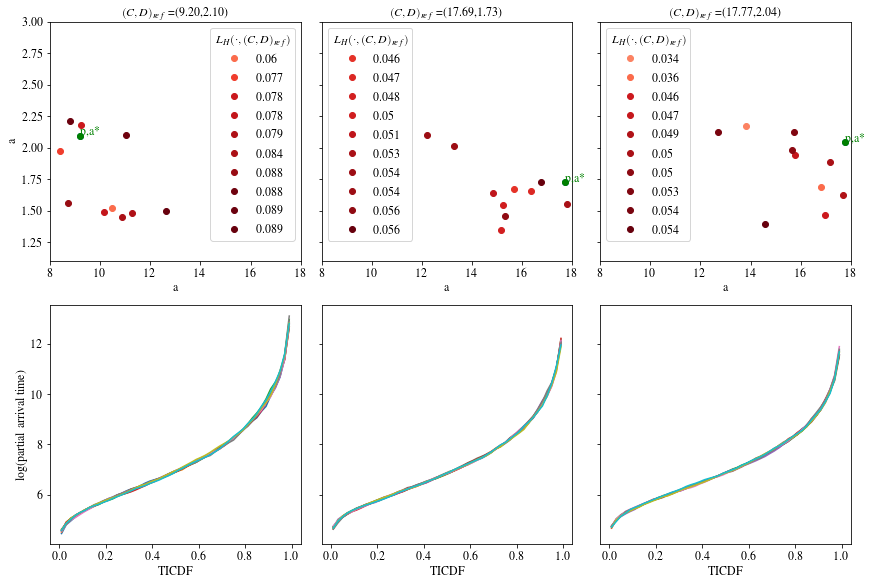

In [19]:
##calculate the hellinger loss of all cdfs with the first cdf
def hel_dist(P, Q):
  return np.sqrt(sum((np.sqrt(P) - np.sqrt(Q))**2))

# fig.savefig('C_d.pdf', format='pdf',bbox_inches='tight')
np.random.seed(88)
ind = np.random.randint(1, 3001, 6)-1
fig, axs = plt.subplots(2, 3, figsize=(12, 8),  sharey='row',
                             constrained_layout=True)
fig2, axs2 = plt.subplots(2,3, figsize=(12, 8),  sharey='row',
                             constrained_layout=True)
for k in range(3):
  mse_cdf = np.zeros((len(P_cdf)))
  hel_dists = np.zeros((len(P_cdf)))
  time1 = time.time()
  for i in range(len(P_cdf)):
    mse_cdf[i] = sum((P_cdf[i] - P_cdf[ind[k]])**2)
  time2 = time.time()
  print('mse time: ', time2-time1)
  time1 = time.time()
  for i in range(len(P_cdf)):
    hel_dists[i] = hel_dist(P_cdf[i], P_cdf[ind[k]])
  time2 = time.time()
  print('hellinger time: ', time2-time1)
  min_cdf_10 = np.argpartition(mse_cdf, 11)
  min_hel_10 = np.argpartition(hel_dists, 11)

  dist = mse_cdf[min_cdf_10[:11]]
  ind_dist = np.argsort(dist)
  min10 = C_d[min_cdf_10[:11]]
  dist, min10 = dist[ind_dist], min10[ind_dist]
  y1 = min10[:,0]
  y2 = min10[:,1]
  dist_hel = hel_dists[min_hel_10[:11]]
  ind_dist_hel = np.argsort(dist_hel)
  min10_hel = C_d[min_hel_10[:11]]
  dist_hel, min10_hel = dist_hel[ind_dist_hel], min10_hel[ind_dist_hel]
  y1_hel = min10_hel[:,0]
  y2_hel = min10_hel[:,1]
  axs[0,k].plot(y1[0], y2[0], "o")
  axs2[0,k].plot(y1_hel[0], y2_hel[0], 'o')
  color_map = plt.get_cmap("Reds")
  norm = mpl.colors.Normalize(vmin=min(dist), vmax=max(dist))
  for i,txt in enumerate(dist):
      if y1[i] == C_d[ind[k], 0] and y2[i] == C_d[ind[k], 1]:
        axs[0,k].plot(y1[i], y2[i], "o", color = 'g', )
        axs[0,k].annotate('{p,a}*', (C_d[ind[k], 0], C_d[ind[k], 1]), color = 'g')
      else:
        axs[0,k].plot(y1[i], y2[i], "o", color = color_map(norm(txt)), 
                      label=round(txt, 3))

      if y1_hel[i] == C_d[ind[k], 0] and y2_hel[i] == C_d[ind[k], 1]:
        axs2[0,k].plot(y1_hel[i], y2_hel[i], "o", color = 'g')
        axs2[0,k].annotate('{p,a}*', (C_d[ind[k], 0], C_d[ind[k], 1]), color = 'g')
      else:
        axs2[0,k].plot(y1_hel[i], y2_hel[i], "o", color = color_map(norm(txt)),
              label=round(dist_hel[i], 3))
  axs[0,k].legend(title='L2:')
  axs[0,k].set_xlabel("p")
  axs[0,k].set_xlim(8, 18)
  axs[0,k].set_title(
      "$(p,a)_{ref}$" + " =({:.2f},{:.2f})".format(C_d[ind[k], 0], C_d[ind[k], 1])
      )
      # r"\ is Number $\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
      # fontsize=16, color='r')
  axs2[0,k].legend(title='$L_H(\cdot, (C,D)_{ref})$')
  axs2[0,k].set_xlabel("a")
  axs2[0,k].set_xlim(8, 18)
  #guofeng modified
  axs2[0,k].set_title(
      "$(C,D)_{ref}$" + " =({:.2f},{:.2f})".format(C_d[ind[k], 0], C_d[ind[k], 1])
      )
  for j in range(10):
    axs[1,k].plot(np.linspace(0.01, 0.99, 50), P_cdf[min_cdf_10[j]])
    axs[1,k].set_xlabel('TICDF')
    axs2[1,k].plot(np.linspace(0.01, 0.99, 50), P_cdf[min_hel_10[j]])
    axs2[1,k].set_xlabel('TICDF')
axs[0,0].set_ylabel("p")
axs[0,0].set_ylim(1.1,3)
axs2[0,0].set_ylabel("a")
axs2[0,0].set_ylim(1.1,3)
axs[1,0].set_ylabel('log(partial arrival time)')
axs2[1,0].set_ylabel('log(partial arrival time)')
# fig.suptitle('L2 distance')
# fig2.suptitle('Hellinger')    
fig.savefig(path+'illpose.pdf', format='pdf',bbox_inches='tight')
fig2.savefig(path+'illpose_hellinger.pdf', bbox_inches='tight')

In [20]:
print('how many gpu: ', torch.cuda.device_count())
# USE_GPU = False
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', torch.cuda.get_device_name())

how many gpu:  1
using device: Tesla T4


## grid searching

In [21]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

path = '/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/'
files = os.listdir(path)
folders = [os.path.join(path, i) for i in files if '.' not in i]
latest_folder = max(folders, key=os.path.getmtime)
latest_folder='/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/01-07-2023-16-12-37/'
print(latest_folder)
check_data = torch.load(latest_folder+'/ckp.pt')
best_config = check_data['Best trial config']
best_trained_model = Net(ls=best_config['ls'], n_l=best_config['n_l']).to(device)


continue_path = latest_folder + '/continue_train'
dict_data = torch.load(continue_path+'/ckp.pt')
best_trained_model.load_state_dict( dict_data['model_state_dict'])
print(best_trained_model)

/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/01-07-2023-16-12-37/
Net(
  (fc1): Linear(in_features=6, out_features=512, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (fcend): Linear(in_features=256, out_features=50, bias=True)
)


In [22]:
os.getcwd()

'/content'

In [23]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=500,
    shuffle=True,
    num_workers=0)
test_loss = 0.
test_steps = 0
for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_trained_model(inputs)

        loss = hel_loss(outputs, targets)
        # loss = nn.MSELoss()
        # loss = loss(outputs, targets)
        test_loss += loss.cpu().numpy()
        test_steps += 1
print('testing loss: ', test_loss/test_steps)

testing loss:  0.16037728637456894


[0.12488206 0.13318008 0.12855157 0.859765   0.06712715 0.0735024
 0.9159153  0.05054039]


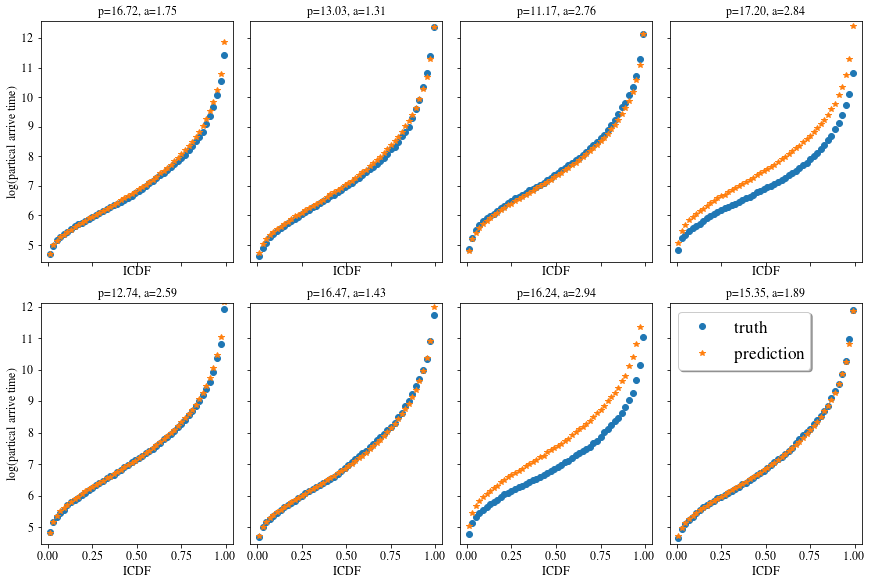

In [24]:
np.random.seed(88)
with torch.no_grad():
    inputs, targets = testset[[np.random.randint(0, len(testset), size=(8,))]]
    inputs, targets = inputs.to(device), targets.to(device)
    best_trained_model.eval()
    outputs = best_trained_model(inputs)
print(np.sqrt(np.sum((np.sqrt(outputs.cpu().numpy()) - np.sqrt(targets.cpu().numpy()))**2, axis=1)))
plot_prediction(outputs.cpu().numpy(), targets.cpu().numpy(), inputs.cpu().numpy(), title=path)


In [25]:
def plot_prediction1(outputs, targets, inputs, title=''):

    fig1, axs = plt.subplots(len(targets)//4, 4, figsize=(12,4), 
                             sharey = 'row', sharex=True,
                             constrained_layout=True)
    axs = axs.flat
    ylims = [
              [np.min(targets[:4,])-0.2, np.max(targets[:4,])+0.2],
              #[np.min(targets[4:,])-0.2, np.max(targets[4:,])+0.2]
    ]
    zeros_ind = outputs==0.   
    for ax, i, out, tar in zip(axs, range(len(outputs)), outputs, targets):
        CD =  inputs[i][:2]
        ax.set_title('p={:.2f}, a={:.2f}'.format(CD[0], CD[1]))
        x = np.linspace(0.01, 0.99, 50)
        ax.plot(x, tar, 'o', label='truth')
        ax.plot(x, out, '*', label='prediction')
        ylim = ylims[0] if i<4 else ylims[1]
        if np.any(zeros_ind):
            ax.plot(x[zeros_ind[i]], 
                    [ylim[0]+0.1 for i in range(len(x[zeros_ind[i]]))],
                    'x', color='r', label='zero predictions')

        ax.set_ylim(ylim)
        ax.set_xlabel('ICDF')
        if i==0:
          ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    axs[0].set_ylabel('log(partical arrive time)')
    #axs[4].set_ylabel('log(partical arrive time)')
    plt.show()
    fig1.savefig(title+'/test1.pdf')
    fig1.savefig(title+'/test1.png')
    return

[0.12488206 0.13318008 0.12855157 0.859765  ]


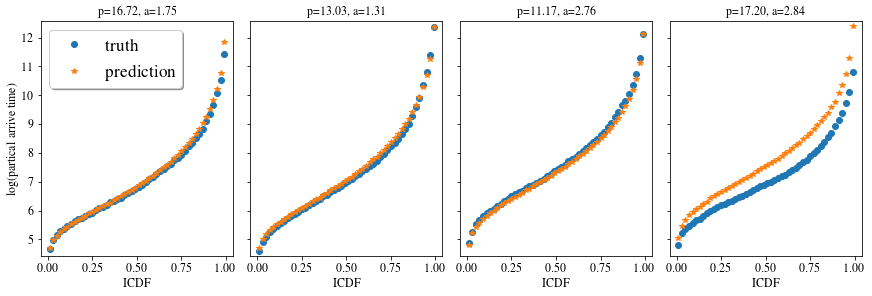

In [26]:
np.random.seed(88)
with torch.no_grad():
    inputs, targets = testset[[np.random.randint(0, len(testset), size=(4,))]]
    inputs, targets = inputs.to(device), targets.to(device)
    best_trained_model.eval()
    outputs = best_trained_model(inputs)
print(np.sqrt(np.sum((np.sqrt(outputs.cpu().numpy()) - np.sqrt(targets.cpu().numpy()))**2, axis=1)))
plot_prediction1(outputs.cpu().numpy(), targets.cpu().numpy(), inputs.cpu().numpy(), title=path)

In [27]:
sig = 0.4

In [28]:
start = time.time()
## grid searching
C = np.linspace(8, 18, 10000)
# D = k*C +b
D = np.linspace(1.1, 3, 1000)
C, D = np.meshgrid(C, D)
mesh_shape = C.shape
C, D = np.reshape(C,(-1,)), np.reshape(D, (-1))
all_pairs = np.array([C, D, C**(1/D), C**(-D), C*D, 1/D]).T
best_trained_model.eval()
all_outputs = torch.FloatTensor([]).to(device)
batch_size = 50000
with torch.no_grad():
    for i in range(0, len(all_pairs), batch_size):
        if i+batch_size < len(all_pairs):
            batch = all_pairs[i:i+batch_size]
        else:
            batch = all_pairs[i:]
        batch_input = torch.FloatTensor(batch).to(device)
        outputs = best_trained_model(batch_input)
        all_outputs = torch.cat((all_outputs, outputs), 0)

end1 = time.time()


15.969104766845703 2.064523458480835
12.742549896240234 2.5906147956848145
16.84481430053711 2.408007860183716


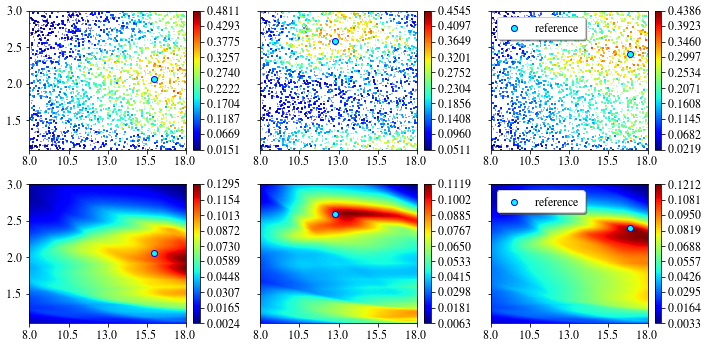

In [29]:
np.random.seed(444)
ind = np.random.randint(0, len(testset), size=3)
list(enumerate(ind));
fig, axs = plt.subplots(2, 3, figsize=(10, 5),  sharey='row',)
axs = axs.flat
for i_ind, i in enumerate(ind):
    ref_C = testset[i][0][0].cpu().numpy().item() ## C
    ref_D = testset[i][0][1].cpu().numpy().item()
    ref_input = testset[i][0].to(device)
    
    ## plot the scatter plot with the dataset:
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].cpu().numpy()
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = np.sqrt(np.sum((np.sqrt(P_cdf) - np.sqrt(ref_out))**2, axis=1))
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/101)*(1.9/101))
    ax = axs[i_ind]
    c01map = ax.scatter(C_d[:,0], C_d[:,1], c=p, cmap='jet', marker=",", s = 0.5,
                        # interpolation='nearest',
              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
              vmin=p.min(), vmax = p.max(),
              # origin='lower',aspect='auto'
              )

    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')

    ## plot the map with the nn surrogate
    ax = axs[i_ind+3]
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].to(device)
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = torch.sqrt(torch.sum((torch.sqrt(all_outputs) - torch.sqrt(ref_out))**2, dim=1))
    all_hel_loss = all_hel_loss.data.cpu().numpy()
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/9999)*(1.9/999))
    p = np.reshape(p, mesh_shape)
    c01map = ax.imshow(p, cmap='jet', interpolation='nearest',
              extent=[C.min(), C.max(), D.min(), D.max()],
              vmin=p.min(), vmax = p.max(),
              origin='lower',aspect='auto')
    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')
    print(ref_C,ref_D)
axs[2].legend(shadow=True,loc='upper left')
ax.legend(shadow=True,loc='upper left')
plt.tight_layout()
fig.savefig(continue_path+'/posterior1.pdf', format='pdf',bbox_inches='tight')
plt.show()
end2 = time.time()

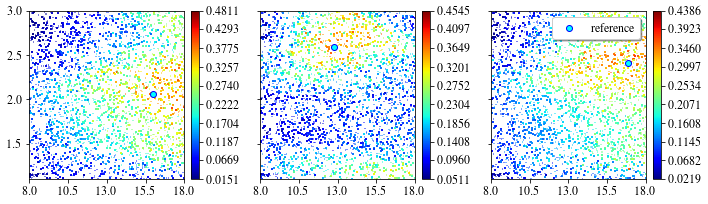

In [30]:
## postrior with the orginal dataset

## grid searching
# P_cdf = np.asarray(P_cdf)
# C_d = np.asarray(C_d)

fig, axs = plt.subplots(1, 3, figsize=(10, 3),  sharey='row', sharex='col')

for i, ax in zip(ind, axs.flat):
    ref_C = testset[i][0][0].cpu().numpy().item() ## C
    ref_D = testset[i][0][1].cpu().numpy().item()
    
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].cpu().numpy()
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = np.sqrt(np.sum((np.sqrt(P_cdf) - np.sqrt(ref_out))**2, axis=1))
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/101)*(1.9/101))

    c01map = ax.scatter(C_d[:,0], C_d[:,1], c=p, cmap='jet', marker=",", s = 0.5,
                        # interpolation='nearest',
              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
              vmin=p.min(), vmax = p.max(),
              # origin='lower',aspect='auto'
              )
    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')
ax.legend(shadow=True, loc='upper right')
    # ax1.set_ylim([0, 12])
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
plt.tight_layout()
fig.savefig(continue_path+'/density_sparse1.pdf', format='pdf',bbox_inches='tight')
plt.show()
# end2 = time.time()

15.969104766845703 2.064523458480835
12.742549896240234 2.5906147956848145
16.84481430053711 2.408007860183716


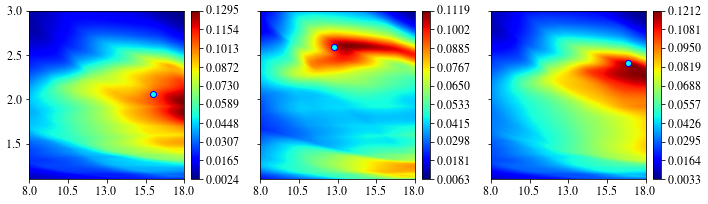

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3),  sharey='row',)
axs = axs.flat
for i_ind, i in enumerate(ind):
    ref_C = testset[i][0][0].cpu().numpy().item() ## C
    ref_D = testset[i][0][1].cpu().numpy().item()
    ref_input = testset[i][0].to(device)
    
   
    ax = axs[i_ind]
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].to(device)
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = torch.sqrt(torch.sum((torch.sqrt(all_outputs) - torch.sqrt(ref_out))**2, dim=1))
    all_hel_loss = all_hel_loss.data.cpu().numpy()
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/9999)*(1.9/999))
    p = np.reshape(p, mesh_shape)
    c01map = ax.imshow(p, cmap='jet', interpolation='nearest',
              extent=[C.min(), C.max(), D.min(), D.max()],
              vmin=p.min(), vmax = p.max(),
              origin='lower',aspect='auto')
    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')
    print(ref_C,ref_D)
    # if i_ind==0:
    #   ax.legend(shadow=True,loc='upper left')
#axs[2].legend(shadow=True,loc='upper left')
#ax.legend(shadow=True,loc='upper left')
plt.tight_layout()
fig.savefig(continue_path+'/posterior1_new.pdf', format='pdf',bbox_inches='tight')
plt.show()
end2 = time.time()

9.521668434143066 1.604429841041565
12.869091033935547 2.3721823692321777
12.70516586303711 2.8601579666137695


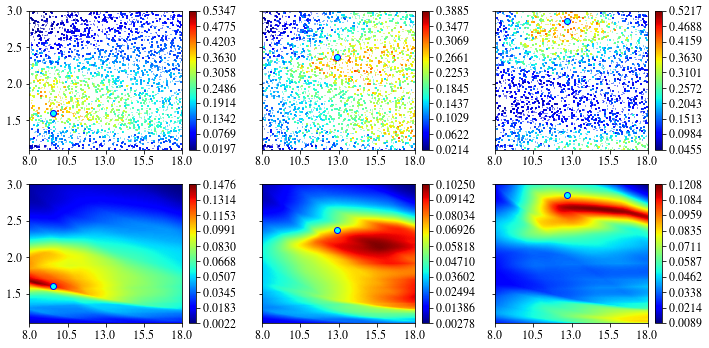

In [43]:
np.random.seed(333)
ind = np.random.randint(0, len(testset), size=3)
ind=[350,398,180]
list(enumerate(ind));
fig, axs = plt.subplots(2, 3, figsize=(10, 5),  sharey='row',)
axs = axs.flat
for i_ind, i in enumerate(ind):
    ref_C = testset[i][0][0].cpu().numpy().item() ## C
    ref_D = testset[i][0][1].cpu().numpy().item()
    ref_input = testset[i][0].to(device)
    
    ## plot the scatter plot with the dataset:
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].cpu().numpy()
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = np.sqrt(np.sum((np.sqrt(P_cdf) - np.sqrt(ref_out))**2, axis=1))
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/101)*(1.9/101))
    ax = axs[i_ind]
    c01map = ax.scatter(C_d[:,0], C_d[:,1], c=p, cmap='jet', marker=",", s = 0.5,
                        # interpolation='nearest',
              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
              vmin=p.min(), vmax = p.max(),
              # origin='lower',aspect='auto'
              )

    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')

    ## plot the map with the nn surrogate
    ax = axs[i_ind+3]
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].to(device)
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = torch.sqrt(torch.sum((torch.sqrt(all_outputs) - torch.sqrt(ref_out))**2, dim=1))
    all_hel_loss = all_hel_loss.data.cpu().numpy()
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/9999)*(1.9/999))
    p = np.reshape(p, mesh_shape)
    c01map = ax.imshow(p, cmap='jet', interpolation='nearest',
              extent=[C.min(), C.max(), D.min(), D.max()],
              vmin=p.min(), vmax = p.max(),
              origin='lower',aspect='auto')
    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')
    print(ref_C,ref_D)
# axs[2].legend(shadow=True,loc='upper left')
# ax.legend(shadow=True,loc='upper left')
plt.tight_layout()
fig.savefig(continue_path+'/posterior2.pdf', format='pdf',bbox_inches='tight')
plt.show()
end2 = time.time()

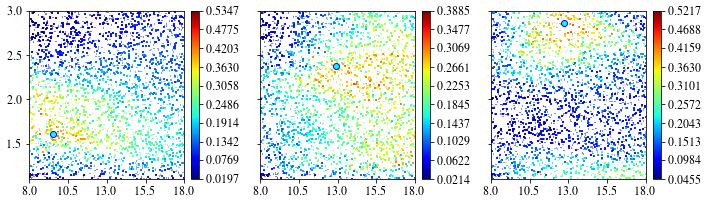

In [44]:
## postrior with the orginal dataset

## grid searching
# P_cdf = np.asarray(P_cdf)
# C_d = np.asarray(C_d)

ind=[350,398,180]
list(enumerate(ind));

fig, axs = plt.subplots(1, 3, figsize=(10, 3),  sharey='row', sharex='col')

for i, ax in zip(ind, axs.flat):
    ref_C = testset[i][0][0].cpu().numpy().item() ## C
    ref_D = testset[i][0][1].cpu().numpy().item()
    
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].cpu().numpy()
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = np.sqrt(np.sum((np.sqrt(P_cdf) - np.sqrt(ref_out))**2, axis=1))
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/101)*(1.9/101))

    c01map = ax.scatter(C_d[:,0], C_d[:,1], c=p, cmap='jet', marker=",", s = 0.5,
                        # interpolation='nearest',
              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
              vmin=p.min(), vmax = p.max(),
              # origin='lower',aspect='auto'
              )
    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')
    if i==166:
      ax.legend(shadow=True, loc='upper right')
    # ax1.set_ylim([0, 12])
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
plt.tight_layout()
fig.savefig(continue_path+'/density_sparse2.pdf', format='pdf',bbox_inches='tight')
plt.show()
# end2 = time.time()

9.521668434143066 1.604429841041565
12.869091033935547 2.3721823692321777
12.70516586303711 2.8601579666137695


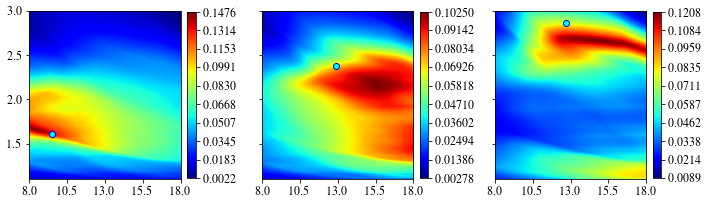

In [45]:
np.random.seed(333)
ind = np.random.randint(0, len(testset), size=3)
ind=[350,398,180]
list(enumerate(ind));
fig, axs = plt.subplots(1, 3, figsize=(10, 3),  sharey='row',)
axs = axs.flat
for i_ind, i in enumerate(ind):
    ref_C = testset[i][0][0].cpu().numpy().item() ## C
    ref_D = testset[i][0][1].cpu().numpy().item()
    ref_input = testset[i][0].to(device)
    
    ## plot the scatter plot with the dataset:
#    with torch.no_grad():
#        # ref_out = best_trained_model(ref_input)
##        ref_out = testset[i][1].cpu().numpy()
#        # ref_out = ref_out.cpu().detach().numpy()
#        all_hel_loss = np.sqrt(np.sum((np.sqrt(P_cdf) - np.sqrt(ref_out))**2, axis=1))
#    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
#    p = p/np.sum(p*(10/101)*(1.9/101))
#    ax = axs[i_ind]
##    c01map = ax.scatter(C_d[:,0], C_d[:,1], c=p, cmap='jet', marker=",", s = 0.5,
#                        # interpolation='nearest',
#              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
 #             vmin=p.min(), vmax = p.max(),
 #             # origin='lower',aspect='auto'
 #             )
#
 #   ax.set_xlim(8, 18)
 #   ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
 #   ax.set_ylim(1.1, 3)
 #   # ax.set_xlabel('C [-]')
 #   # ax.set_ylabel('D [-]')
 #   v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
 #   fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
 #   ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')

    ## plot the map with the nn surrogate
    ax = axs[i_ind]
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].to(device)
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = torch.sqrt(torch.sum((torch.sqrt(all_outputs) - torch.sqrt(ref_out))**2, dim=1))
    all_hel_loss = all_hel_loss.data.cpu().numpy()
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/9999)*(1.9/999))
    p = np.reshape(p, mesh_shape)
    c01map = ax.imshow(p, cmap='jet', interpolation='nearest',
              extent=[C.min(), C.max(), D.min(), D.max()],
              vmin=p.min(), vmax = p.max(),
              origin='lower',aspect='auto')
    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')
    print(ref_C,ref_D)
    # if i_ind==0:
    #   ax.legend(shadow=True,loc='upper left')
#axs[2].legend(shadow=True,loc='upper left')
#ax.legend(shadow=True,loc='upper left')
plt.tight_layout()
fig.savefig(continue_path+'/posterior3.pdf', format='pdf',bbox_inches='tight')
plt.show()
end2 = time.time()

In [35]:
print('run {} forward simulations needs {:.2f} seconds'.format(len(all_hel_loss), end1-start))
print('compute the posterior for 6 simulations and plotting takes {:.2f} seconds'.format(end2-end1))

run 10000000 forward simulations needs 8.24 seconds
compute the posterior for 6 simulations and plotting takes 54.29 seconds


In [36]:
import numpy
# start = time.time()
## grid searching
C = C_d[:,0]
# D = k*C +b
D = C_d[:,1]
#C, D = np.meshgrid(C, D)
#mesh_shape = C.shape
#C, D = np.reshape(C,(-1,)), np.reshape(D, (-1))
all_pairs = np.array([C, D, C**(1/D), C**(-D), C*D, 1/D]).T
best_trained_model.eval()
all_outputsv1 = torch.FloatTensor([]).to(device)
batch_size = 50000
batch_input = torch.FloatTensor(all_pairs).to(device)
outputs = best_trained_model(batch_input)
all_outputsv1 = torch.cat((all_outputsv1, outputs), 0)
outputsv2 = outputs.data.cpu().numpy()
#relative_error1 = np.sqrt(np.sum((np.sqrt(P_cdf)-np.sqrt(outputsv2))**2, axis=1))
#error1 = 1/(sig*np.sqrt(2*np.pi))*np.exp(-relative_error1/(2*sig**2))#H distance
error2 = np.sqrt(np.sum(((P_cdf)-(outputsv2))**2, axis=1))#
#definnation of L2 error
error3 = (np.sum(((P_cdf)-(outputsv2))**2, axis=1))
sumofoutputsv3=(np.sum(((P_cdf))**2, axis=1))
relative_error3 = np.sqrt(error3/sumofoutputsv3) 
end1 = time.time()
print(len(all_outputsv1))
print(outputs)
print(all_outputsv1)
print(P_cdf)
print(outputsv2)
#print(error1)
print(error2)

3000
tensor([[ 4.7046,  5.0557,  5.2583,  ..., 11.1254, 11.6879, 12.8200],
        [ 4.8469,  5.1491,  5.3125,  ..., 10.1005, 10.6353, 11.7237],
        [ 4.7539,  5.0797,  5.2516,  ..., 10.4426, 11.0054, 12.0987],
        ...,
        [ 4.5687,  4.8745,  5.0426,  ..., 10.4576, 11.0566, 12.2175],
        [ 4.7469,  5.1993,  5.4232,  ..., 10.8793, 11.4322, 12.5125],
        [ 4.6601,  4.9685,  5.1311,  ..., 10.8320, 11.4432, 12.6145]],
       device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 4.7046,  5.0557,  5.2583,  ..., 11.1254, 11.6879, 12.8200],
        [ 4.8469,  5.1491,  5.3125,  ..., 10.1005, 10.6353, 11.7237],
        [ 4.7539,  5.0797,  5.2516,  ..., 10.4426, 11.0054, 12.0987],
        ...,
        [ 4.5687,  4.8745,  5.0426,  ..., 10.4576, 11.0566, 12.2175],
        [ 4.7469,  5.1993,  5.4232,  ..., 10.8793, 11.4322, 12.5125],
        [ 4.6601,  4.9685,  5.1311,  ..., 10.8320, 11.4432, 12.6145]],
       device='cuda:0', grad_fn=<CatBackward0>)
[[ 4.62581055  4.97395656  5.1

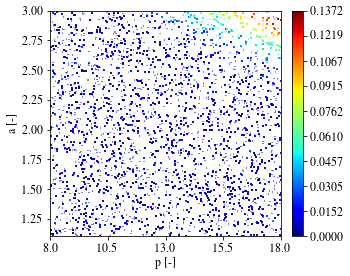

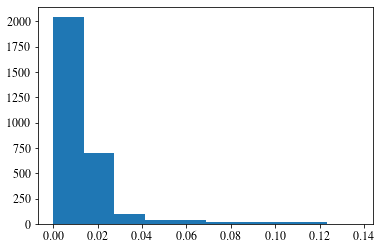

In [37]:
## relative error of particle arrivale time expectation

## grid searching
# P_cdf = np.asarray(P_cdf)
# C_d = np.asarray(C_d)

fig, ax = plt.subplots(1, 1, figsize=(5, 4),  sharey='row', sharex='col')
p = np.sum(P_cdf*0.01, axis=1)
q = torch.sum(all_outputsv1*0.01,dim=1)
q = q.data.cpu().numpy()
n=abs(p-q)/p
c01map = ax.scatter(C_d[:,0], C_d[:,1], c=n, cmap='jet', marker=",", s = 0.5,
                        # interpolation='nearest',
              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
              vmin=n.min(), vmax = n.max(),
              # origin='lower',aspect='auto'
           )

    # ax1.set_ylim([0, 12])
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
ax.set_xlim(8, 18)
ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
ax.set_ylim(1.1, 3)
ax.set_xlabel('p [-]')
ax.set_ylabel('a [-]')
v1 = np.linspace(np.min(n), np.max(n), 10, endpoint=True)
fig.colorbar(c01map, ax=ax, fraction=0.08, pad=0.04,ticks=v1,)
plt.tight_layout()
fig.savefig(continue_path+'/error_expectation.pdf', format='pdf',bbox_inches='tight')
plt.show()
np.savetxt(continue_path+'error0.txt',n)
plt.hist(n)
plt.show()

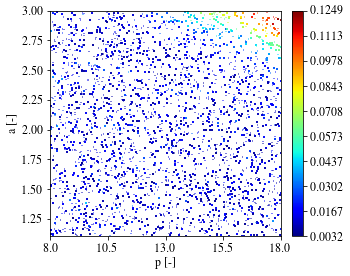

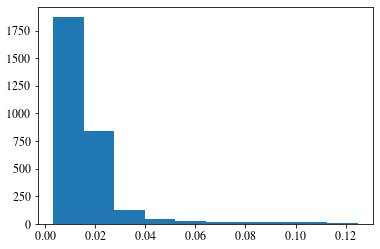

In [38]:
#relative error2 of particle breakthrough curves

sumofoutputsv2=np.sqrt(np.sum(((outputsv2))**2, axis=1))
relative_error2 = error2/sumofoutputsv2 
fig, ax = plt.subplots(1, 1, figsize=(5, 4),  sharey='row', sharex='col')

c01map = ax.scatter(C_d[:,0], C_d[:,1], c=relative_error2, cmap='jet', marker=",", s = 0.5,
                        # interpolation='nearest',
              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
              vmin=relative_error2.min(), vmax = relative_error2.max(),
              # origin='lower',aspect='auto'
           )

    # ax1.set_ylim([0, 12])
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
ax.set_xlim(8, 18)
ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
ax.set_ylim(1.1, 3)
ax.set_xlabel('p [-]')
ax.set_ylabel('a [-]')
v1 = np.linspace(np.min(relative_error2), np.max(relative_error2), 10, endpoint=True)
fig.colorbar(c01map, ax=ax, fraction=0.08, pad=0.04,ticks=v1,)
plt.tight_layout()
fig.savefig(continue_path+'/error_points2.pdf', format='pdf',bbox_inches='tight')
plt.show()
plt.hist(relative_error2)
plt.show()
np.savetxt(continue_path+'error2.txt',relative_error2)

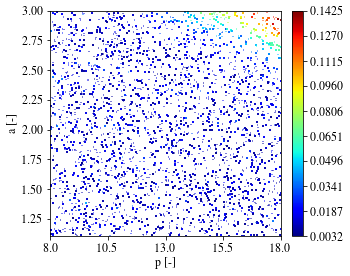

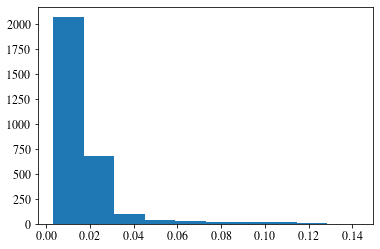

In [39]:
#relative error3 of particle breakthrough curves


fig, ax = plt.subplots(1, 1, figsize=(5, 4),  sharey='row', sharex='col')

c01map = ax.scatter(C_d[:,0], C_d[:,1], c=relative_error3, cmap='jet', marker=",", s = 0.5,
                        # interpolation='nearest',
              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
              vmin=relative_error3.min(), vmax = relative_error3.max(),
              # origin='lower',aspect='auto'
           )

    # ax1.set_ylim([0, 12])
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
ax.set_xlim(8, 18)
ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
ax.set_ylim(1.1, 3)
ax.set_xlabel('p [-]')
ax.set_ylabel('a [-]')
v1 = np.linspace(np.min(relative_error3), np.max(relative_error3), 10, endpoint=True)
fig.colorbar(c01map, ax=ax, fraction=0.08, pad=0.04,ticks=v1,)
plt.tight_layout()
fig.savefig(continue_path+'/error_points3.pdf', format='pdf',bbox_inches='tight')
plt.show()
plt.hist(relative_error3)
plt.show()
np.savetxt(continue_path+'error3.txt',relative_error3)